In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy.signal as ss
from numpy import linalg as LA

teta = [-10,3.5] #degrees
D = len(teta)
M = 10
thresh_real = 0
thresh_im = 0

In [2]:
def Matrix(M, teta):
    D = len(teta)
    teta = np.radians(teta)
    A = np.zeros((M, D), dtype=complex)
    for j in range(D):
        A[:, j] = np.exp(-1j * np.pi*np.arange(M)*np.sin(teta[j]))
    return A
A = Matrix(M, teta)

In [3]:
def observ(SNR,snap,quantize):
    global A
    real_s = np.random.normal(0, 1/math.sqrt(2),(D,snap))
    im_s = np.random.normal(0, 1/math.sqrt(2),(D,snap))
    s = real_s + 1j*im_s
    s_samp = s.reshape(D,snap)

    real_n = np.random.normal(0, (10**(-SNR/20))/math.sqrt(2),(M,snap))
    im_n = np.random.normal(0, (10**(-SNR/20))/math.sqrt(2),(M,snap))
    n = real_n + 1j*im_n
    n_samp = n.reshape(M,snap)

    x_a_samp = (A@s_samp)+n_samp
    x_q_samp = (1/math.sqrt(2))*(np.sign(x_a_samp.real-(thresh_real))+(1j*(np.sign(x_a_samp.imag-((thresh_im))))))
    if quantize == 1:
        return x_q_samp
    else:
        return x_a_samp

def covariance(v1,v2): #TODO
    normv1 = np.mean(v1,1)
    normv2 = np.mean(v2,1)
    v = v1-normv1.reshape(np.shape(v1)[0],1)
    u = v2 -normv2.reshape(np.shape(v2)[0],1)
    result = [v[:,i].reshape(np.shape(v)[0], 1)@u[:,i].conjugate().transpose().reshape(1, np.shape(u)[0]) for i in range(np.shape(v)[1])]
    return np.sum(result,0)/(np.shape(v)[1]-1)

In [8]:
def music_algorithm(SNR,snapshot,monte,quantize=0):
    error_vec = np.zeros(monte)
    global D, M
    for i in range(monte):
        R = np.cov(observ(SNR,snapshot,quantize))#covariance(observ(SNR,snapshot,quantize),observ(SNR,snapshot,quantize))
        theta_range = np.arange(-90, 91, 1)
        eigvals, eigvecs = np.linalg.eig(R)
        sorted_indices = np.argsort(eigvals.real)[::-1]  # Sort eigenvalues in descending order
        eigvecs_sorted = eigvecs[:, sorted_indices]
        En = eigvecs_sorted[:, D:]
        theta_range = np.radians(theta_range)  # Convert angles to radians
        num_angles = len(theta_range)
        music_spectrum = np.zeros(num_angles)
        for idx, theta in enumerate(theta_range):
            steering_vector = np.exp(-1j * np.pi * np.arange(M) * np.sin(theta))
            music_spectrum[idx] = 1 / np.linalg.norm(En.conj().T @ steering_vector)
        peaks, _ = ss.find_peaks(music_spectrum)
        peaks = list(peaks)
        peaks.sort(key=lambda x:music_spectrum[x])
        teta_vector = np.array(peaks[-D:])
        teta_vector = np.subtract(np.sort(teta_vector),90)
        error_vec[i] = (LA.norm((np.array(teta)-teta_vector))**2)
    return  (((1/(monte*D))*np.sum(error_vec,0))**0.5)#music_spectrum,theta_range,teta_vector #TODO modulo

print(music_algorithm(10,100,1000))
print(music_algorithm(10,100,1000,1))

0.3535533905932738
0.3535533905932738


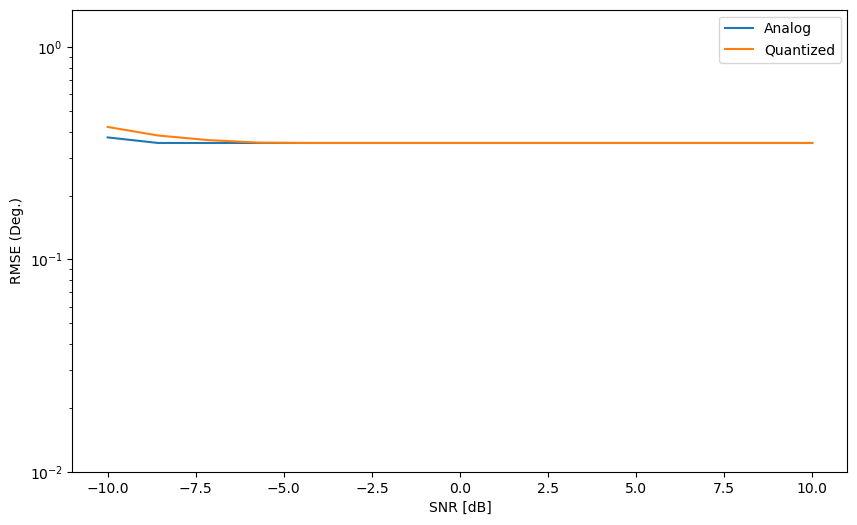

In [6]:
monte1 = 500
snap1=1000
SNR_space = np.linspace(-10,10,15)
error_a = [music_algorithm(SNR_space[i],snap1,monte1) for i in range(len(SNR_space))]
error_q = [music_algorithm(SNR_space[i],snap1,monte1,1) for i in range(len(SNR_space))]

fig = plt.figure(figsize=(10, 6))
plt.plot(SNR_space, error_a, label="Analog")
plt.plot(SNR_space, error_q, label="Quantized")
plt.yscale('log')
plt.ylim(1e-2, 1.5)
plt.ylabel("RMSE (Deg.)")
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

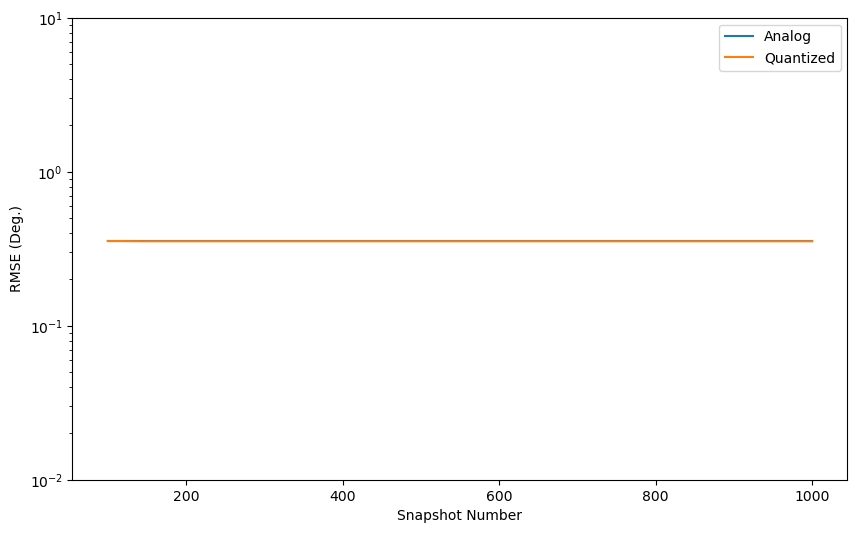

In [5]:
monte2 = 1000
SNR2 = 10
snap_space = np.linspace(100, 1000, 20, dtype=int)
error_a_snap = [music_algorithm(SNR2,snap_space[i],monte2) for i in range(len(snap_space))]
error_q_snap = [music_algorithm(SNR2,snap_space[i],monte2,1) for i in range(len(snap_space))]

fig = plt.figure(figsize=(10, 6))
plt.plot(snap_space, error_a_snap, label="Analog")
plt.plot(snap_space, error_q_snap, label="Quantized")
plt.yscale('log')
plt.ylim(1e-2, 1e1)
plt.ylabel("RMSE (Deg.)")
plt.xlabel("Snapshot Number")
plt.legend()
plt.show()